# Table of Contents

1.  [Introduction: simple generation](#Introduction)
  *  [Initialization](#Introduction)
  *  [Merge](#Introduction)
  *  [Run](#Introduction)
  * [Conservation of identity of communities](#Introduction)
2. [Events chaining](#chaining)
  * [Natural Chaining](#chaining)
  * [Fix Delay](#chaining)
  * [Triggers](#chaining)
3. [Events](#Events)
  * [MERGE/SPLIT](#Events)
  * [BIRTH/DEATH](#Events)
  * [Iterative GROW/SHRINK](#Events)
  * [Iterative Node MIGRATION](#Events)
  * [RESURGENCE](#Events)
  * [Ship of Theseus](#Events)
  * [CONTINUE](#Events)
  * [Custom Event: ASSIGN](#Events)
4. [Generating random scenarios](#Random)
5. [Mixing parameters](#Mixing) 




In [45]:
#%%capture #avoid printing output
#!pip install --upgrade git+https://github.com/Yquetzal/tnetwork.git

In [46]:
%load_ext autoreload
%autoreload 2

import tnetwork as tn
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='Introduction'></a>

# Introduction: simple generation
The generation process works in 2 phases:
1. Define the scenario that you want
2. Run the generation

Everything is done on a community scenario `ComScenario` instance

In [47]:
#First, we create an instance of community scenario
my_scenario = tn.ComScenario()

## Initialization
We can define the original community structure. We set the size of communities and, optionnaly, their names. The function returns objects that represent those communities

In [48]:
[com1,com2] = my_scenario.INITIALIZE([4,6],["com1","com2"])

As soon as we have declared those communities, we can check their number of nodes `n` and number of internal edges `m`. The number of edges is automatically determined by a density function that depends on the size of the community and a global parameter that can be specified when creating the scenario, more on that in the *mixing parameters* section

In [49]:
print(com1)
print(com2)

(com1:n=4,m=5)
(com2:n=6,m=11)


## Merge
Let's define a first operation on these communities. It will be a merge operation, using the function `MERGE`

In [50]:
#We merge com1 and com2. 
absorbing = my_scenario.MERGE([com1,com2],"merged")

## Run
To better understand what is going on, let's run the generation, by calling the function `run`. This has two consequences: 
1. It generates a network corresponding to the described community structure
2. It fixes the details of the number of steps required to do an operation. This is not known in advance, since it depends on a stochastic process

In [51]:
(generated_network,generated_comunities) = my_scenario.run()

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

We can now plot the community structre and the state of the graphs at some times. We can observe that: since the merge is progressive, nodes belong to no community while the operation is in progress (grey color). We can also observe the topology of the graph evolving from two communities to one.

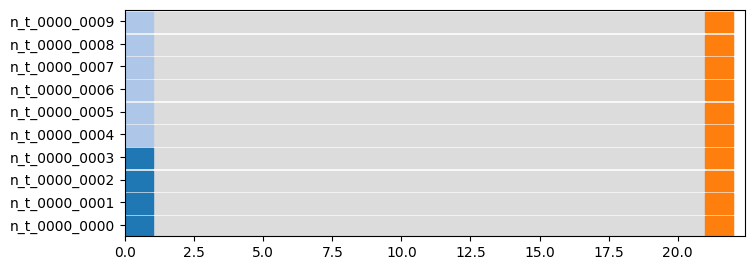

In [52]:
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

In [54]:
last_time = generated_network.end()
times_to_plot = [0,int(last_time/3),int(last_time/3*2),last_time-1]
tn.plot_as_graph(generated_network,generated_comunities,ts=times_to_plot,auto_show=True,width=200,height=200)

ColumnDataSource(id='18550', ...)


Loading BokehJS ...

Row(id='18859', ...)

## Conservation of identity of communities
Note that the name we give to communities is important, it corresponds to their *identity*, i.e., two communities with the same name have the same identity (=same community). 

If we reuse the same scenario, only changing the name of the merged community from "merged" to "com1", we observe in the visualization that the community after the merge has now the same color (i.e., is "the same community") as one of the original ones.

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

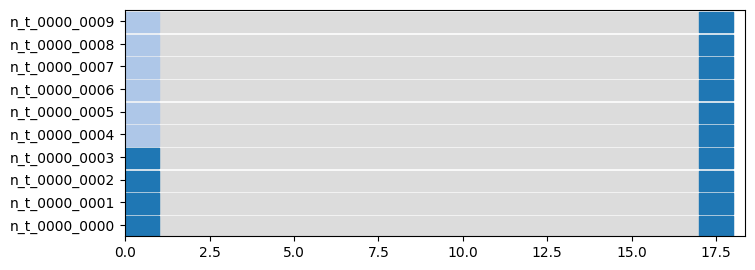

In [55]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([4,6],["com1","com2"])
absorbing = my_scenario.MERGE([com1,com2],"com1")
(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

<a id='chaining'></a>


## Events chaining
Several options are available to control the chaining of operations.

### Natural chaining
First, each operation takes some communities as input. In order for the event to start, the communities required in input must be ready.

100% (2 of 2) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

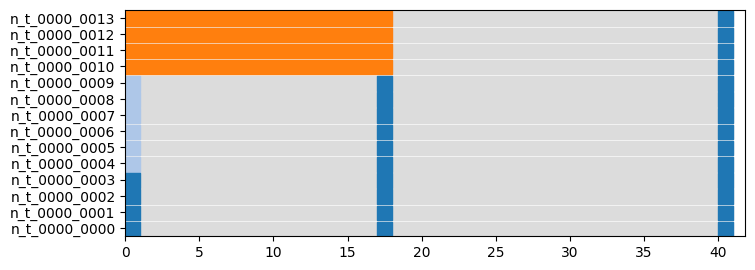

In [56]:
my_scenario = tn.ComScenario()
[com1,com2,com3] = my_scenario.INITIALIZE([4,6,4],["c1","c2","c3"])
absorbing = my_scenario.MERGE([com1,com2],"c1")
absorbing = my_scenario.MERGE([absorbing,com3],"c1")

(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

### Fix delay
It is possible to explicitely require to wait for a given period before starting the event using the `wait` argument of any event

100% (2 of 2) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

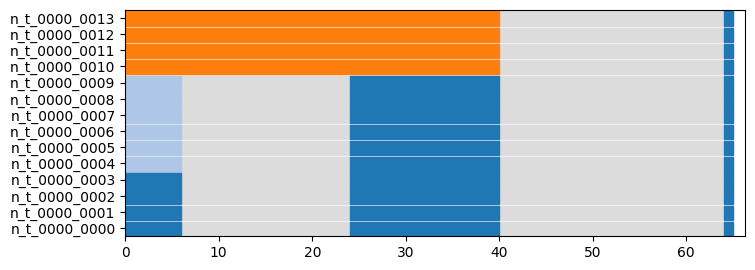

In [57]:
my_scenario = tn.ComScenario()
[com1,com2,com3] = my_scenario.INITIALIZE([4,6,4],["c1","c2","c3"])
absorbing = my_scenario.MERGE([com1,com2],"c1",wait=5)
absorbing = my_scenario.MERGE([absorbing,com3],"c1",wait=15)

(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

### Triggers
One can also use triggers to define that an event can start only when another (unrelated) operations finished. This can be done using the keywork `waitFor`.

In the following example, the second merge, completely unrelated to the first one, is triggered by its end

100% (2 of 2) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

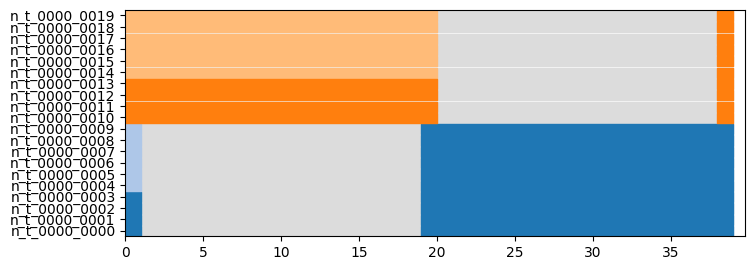

In [58]:
my_scenario = tn.ComScenario()
[com1,com2,com3,com4] = my_scenario.INITIALIZE([4,6,4,6],["c1","c2","c3","c4"])
absorbing1 = my_scenario.MERGE([com1,com2],"c1")
absorbing2 = my_scenario.MERGE([com3,com4],"c3",waitFor=[absorbing1])

(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

<a id='Events'></a>

## Events
Let's now go through the different existing events

### MERGE/SPLIT
We have alredy seen the `MERGE` event, there is a symmetric `SPLIT` event.

100% (2 of 2) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

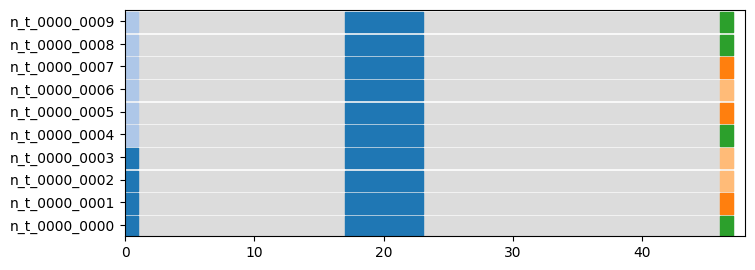

In [59]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([4,6],["c1","c2"])
merged = my_scenario.MERGE([com1,com2],"c1")
my_scenario.SPLIT(merged,["split1","split2","split3"],[3,3,4],wait=5)

(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

In [60]:
last_time = generated_network.end()
times_to_plot = [0,int(last_time/3),int(last_time/3*2),last_time-1]
tn.plot_as_graph(generated_network,generated_comunities,ts=times_to_plot,auto_show=True,width=200,height=200)

ColumnDataSource(id='19222', ...)


Loading BokehJS ...

Row(id='19531', ...)

### BIRTH/DEATH
Communities can appear and disappear.
Note that communities appear progressively, edge by edge.

100% (2 of 2) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

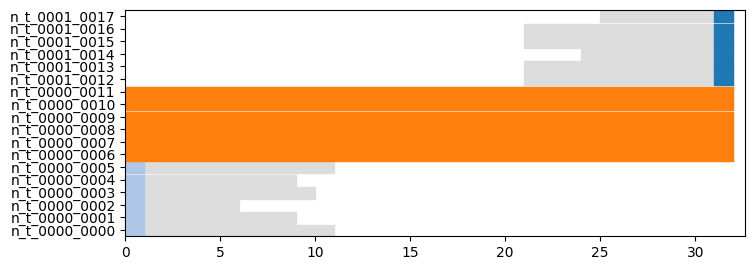

In [61]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([6,6],["c1","c2"])
my_scenario.BIRTH(6,"born",wait=20)
my_scenario.DEATH(com1)

#visualization
(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

### Iterative GROW/SHRINK
It is possible to make a community grow (creating new nodes) or shring (nodes disappear), one node after the other, node by node. It can be used to add/remove a single node too, of course.

A parameter allow to tune the time between each addition/removal

100% (8 of 8) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

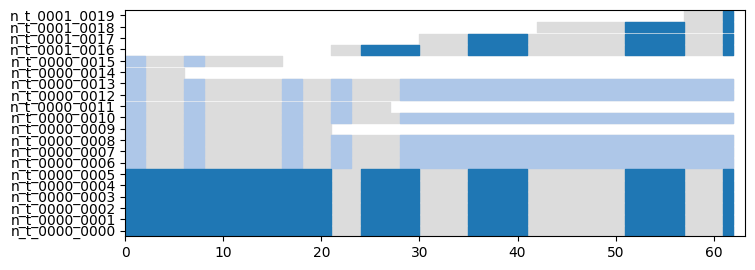

In [62]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([6,10],["c1","c2"])
my_scenario.GROW_ITERATIVE(com1,nb_nodes2Add=4,wait_step=5,wait=20)
my_scenario.SHRINK_ITERATIVE(com2,nb_nodes2remove=4,wait_step=1)

#visualization
(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

### Iterative node MIGRATION
Most of the time, in the real world, when a community change size, it is not by integrating nodes newly created, but by taking nodes from existing communities. This is one this event corresponds to: nodes are moving from one community to another one, one after the other


100% (6 of 6) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

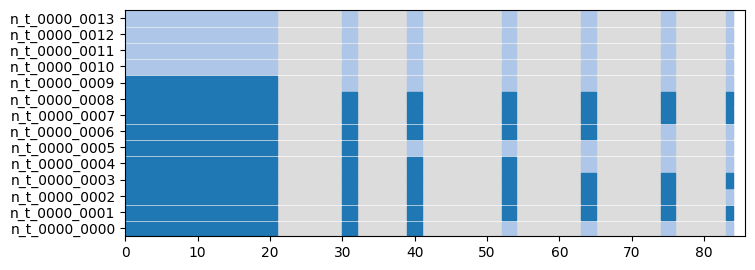

In [63]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([10,4],["c1","c2"])
my_scenario.MIGRATE_ITERATIVE(com1,com2,6,wait_step=1,wait=20)

#visualization
(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

### RESURGENCE
Resurgence is a type of event in which a community disappear for some time, and reappear later, identical to its state before the disappearance. Think of seasonal events for instance, with groups of people/animals/keywords observed together at regular periods. 


100% (6 of 6) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

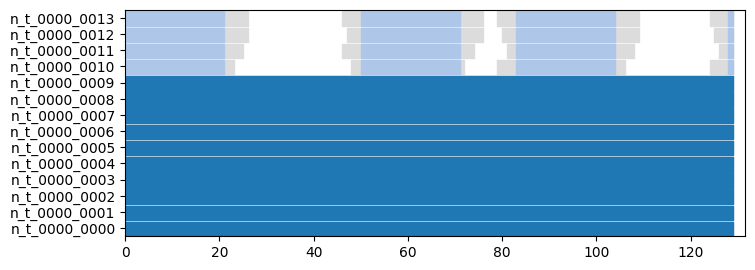

In [64]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([10,4],["c1","c2"])
com2 = my_scenario.RESURGENCE(com2,death_period=20,wait=20)
com2 = my_scenario.RESURGENCE(com2,death_period=3,wait=20)
my_scenario.RESURGENCE(com2,death_period=15,wait=20)



#visualization
(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

### Ship of theseus
The ship of theseus is a typical example of the problem of community identity attribution: starting with a community A, all the nodes are replaced by new ones, one after the other, until none of the original remains. A new community B then appears with exactly the same nodes as the ones originally composing A. Which one is the *correct* A, the community currently labeled A but having no node in common with the original state of A, or the one labelled B ?

100% (7 of 7) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

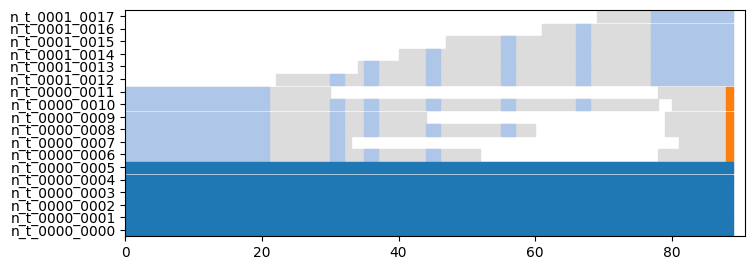

In [65]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([6,6],["c1","c2"])
my_scenario.THESEUS(com2,wait=20)

#visualization
(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

## CONTINUE
The CONTINUE event allows to define a period without change for a community. It is mostly useful to add some period without any change at the end of the scenario.

100% (3 of 3) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

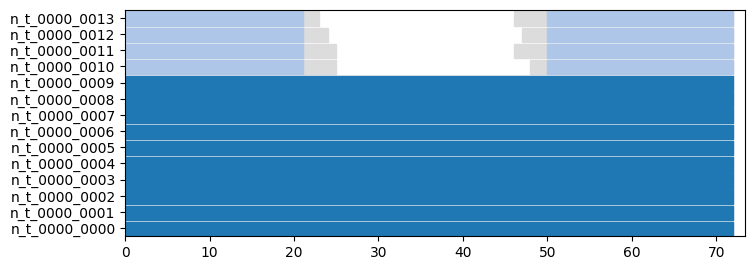

In [66]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([10,4],["c1","c2"])
com2 = my_scenario.RESURGENCE(com2,death_period=20,wait=20)
my_scenario.CONTINUE(com2,wait=20)




#visualization
(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300)

### Custom event: ASSIGN
Most typical scenarios can be described by combining events described above. However, real community evolution might be even more complex than that.
For instance, a community of 10 nodes might split in 2 communities of size 4, while 2 of its nodes merge with two nodes leaving another community to create a new community ! 

We can define any such scenario using the ASSIGN event. Note that in this case, we have to take care of a lower level and describe the event *node by node*


100% (1 of 1) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

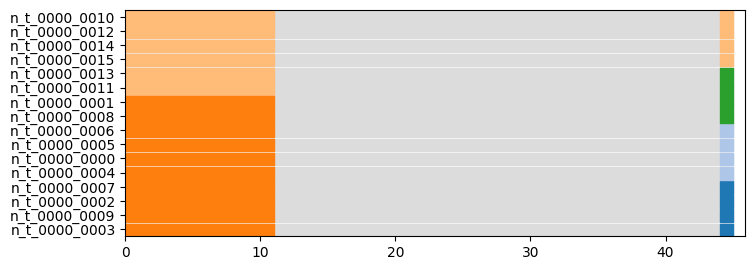

In [67]:
my_scenario = tn.ComScenario()
[com1,com2] = my_scenario.INITIALIZE([10,6],["c1","c2"])
nodesC1 = list(com1.nodes())
nodesC2 = list(com2.nodes())
new_split = [nodesC1[:4],nodesC1[4:8],nodesC1[8:10]+nodesC2[:2],nodesC2[2:]]
my_scenario.ASSIGN(comsBefore=[com1,com2],comsAfter=["C1_split1","C1_split2","new_com","c2"],splittingOut=new_split,wait=10)



#visualization
(generated_network,generated_comunities) = my_scenario.run()
tn.plot_longitudinal(generated_network,generated_comunities,height=300,nodes=nodesC1+nodesC2)

Let's check that the generated network structure do match the described community structure:

In [69]:

last_time = generated_network.end()
times_to_plot = [0,int(last_time/3),int(last_time/3*2),last_time-1]
tn.plot_as_graph(generated_network,generated_comunities,ts=times_to_plot,auto_show=True,width=200,height=200)

ColumnDataSource(id='19896', ...)


Loading BokehJS ...

Row(id='20205', ...)

<a id='Random'></a>

## Generating random scenarios
In what we have seen until now, the scenario was generated manually, by describing precisely the chaining of events.

In typical benchmarks, we want more flexibility, and generate several scenarios with random variations. This can easily been done by writing some code, as examplified below. 
Of course, all choices made have consequences, but the goal of this benchmark is to provide the atomic tools to provide good high level generators...

In [72]:
def generate_graph(nb_com =6,min_size=4,max_size=15,operations=10,mu=0.1):
    print("generating graph with nb_com = ",nb_com)
    prog_scenario = tn.ComScenario(verbose=False,external_density_penalty=mu)
    all_communities = set(prog_scenario.INITIALIZE(np.random.randint(min_size,max_size,size=nb_com)))

    for i in range(operations):
        [com1] = np.random.choice(list(all_communities),1,replace=False)
        all_communities.remove(com1)

        if len(com1.nodes())<max_size and len(all_communities)>0: #merge
            [com2] = np.random.choice(list(all_communities),1,replace=False)
            largest_com = max([com1,com2],key=lambda x: len(x.nodes()))
            merged = prog_scenario.MERGE([com1,com2],largest_com.name(),wait=20)
            all_communities.remove(com2)
            all_communities.add(merged)
        else: #split
            smallest_size = int(len(com1.nodes())/3)
            (com2,com3) = prog_scenario.SPLIT(com1,[prog_scenario._get_new_ID("CUSTOM"),com1.name()],[smallest_size,len(com1.nodes())-smallest_size],wait=20)
            all_communities|= set([com2,com3])
    (dyn_graph,dyn_com) = prog_scenario.run()


    return(dyn_graph,dyn_com)

In [73]:
(generated_network,generated_comunities) = generate_graph(nb_com=6,max_size=10,operations=10)

 80% (8 of 10) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

generating graph with nb_com =  6


100% (10 of 10) |########################| Elapsed Time: 0:00:00 ETA:  00:00:00

/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


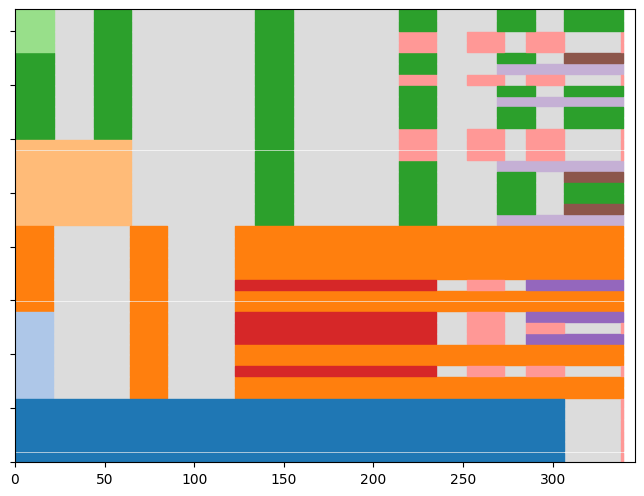

In [74]:
#visualization
tn.plot_longitudinal(generated_network,generated_comunities,height=600)

<a id='Mixing'></a>
## Mixing parameters
Some parameters allow to tune how well defined is the community structure in term of network topology 
* `alpha` determines the internal density of communities. The average degree inside a community is approximately$  (n_{c}-1)^\alpha $ with $n_c$ the number of nodes of community $c$. More precisely, the number of edges inside a community is equal to $d_c=\lceil \frac{n_c(n_c-1)^\alpha}{2} \rceil$. Default value: 0.80
* `external_density_penalty` corresponds to a penalty applied to the formula above for the density of the whole graph. The density among all nodes not in a community is defined as `external_density_penalty`*$d_G$. Default value = 0.05. Beware, with small graphs, larger values often yield poor community structures. Note that edges added using this function are *stable*, i.e., if the community structure do not change, those nodes to not change either, contrary to the next option
* `random_noise` corresponds to a different way to add randomness: this time, for each generated snapshot, a fraction of edges taken at random are rewired. It therefore adds randomness both inside an between communities. Unlike the previous one, choosing this parameter will lead to less edges inside communities than what has been set according to `alpha`. 

We can illustrate this difference by generating a scenario without any community change and plotting the graph at some points.

First, all internal edges exist, no external edges exist

In [75]:
my_scenario = tn.ComScenario(alpha=1,external_density_penalty=0,random_noise=0)
[com1,com2,com3] = my_scenario.INITIALIZE([5,9,12],["c1","c2","c3"])
my_scenario.CONTINUE(com1,wait=4)
(generated_network,generated_comunities) = my_scenario.run()

times_to_plot = [0,1,2]
tn.plot_as_graph(generated_network,generated_comunities,ts=times_to_plot,auto_show=True,width=300,height=300,k=2.5,iterations=100)

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

ColumnDataSource(id='20564', ...)


Loading BokehJS ...

Row(id='20796', ...)

By decreasing `alpha`, communities become less dense.

In [76]:
my_scenario = tn.ComScenario(alpha=0.8,external_density_penalty=0,random_noise=0)
[com1,com2,com3] = my_scenario.INITIALIZE([5,9,12],["c1","c2","c3"])
my_scenario.CONTINUE(com1,wait=4)
(generated_network,generated_comunities) = my_scenario.run()

times_to_plot = [0,1,2]
tn.plot_as_graph(generated_network,generated_comunities,ts=times_to_plot,auto_show=True,width=300,height=300,k=2.5,iterations=100)

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

ColumnDataSource(id='21068', ...)


Loading BokehJS ...

Row(id='21300', ...)

By increasing external_density, some edges appear between communities. Note that, since the community structure do not evolves, the edges between communities do not change (see the article describing the benchmark for more details)

In [77]:
my_scenario = tn.ComScenario(alpha=0.8,external_density_penalty=0.1,random_noise=0)
[com1,com2,com3] = my_scenario.INITIALIZE([5,9,12],["c1","c2","c3"])
my_scenario.CONTINUE(com1,wait=4)
(generated_network,generated_comunities) = my_scenario.run()

times_to_plot = [0,1,2]
tn.plot_as_graph(generated_network,generated_comunities,ts=times_to_plot,auto_show=True,width=300,height=300,k=2.5,iterations=100)

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

ColumnDataSource(id='21572', ...)


Loading BokehJS ...

Row(id='21804', ...)

Instead, if we increase the `random_noise`, edges modifications are present but they differ from one snaphsots to the next, despite the community structure being unchanged

In [78]:
my_scenario = tn.ComScenario(alpha=1,external_density_penalty=0,random_noise=0.1)
[com1,com2,com3] = my_scenario.INITIALIZE([5,9,12],["c1","c2","c3"])
my_scenario.CONTINUE(com1,wait=4)
(generated_network,generated_comunities) = my_scenario.run()

times_to_plot = [0,1,2]
tn.plot_as_graph(generated_network,generated_comunities,ts=times_to_plot,auto_show=True,width=300,height=300,k=2.5,iterations=100)

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

ColumnDataSource(id='22076', ...)


Loading BokehJS ...

Row(id='22308', ...)

We can set all three parameters, but be careful when interpreting the results ! The community structure might quickly degrade

In [79]:
my_scenario = tn.ComScenario(alpha=0.8,external_density_penalty=0.2,random_noise=0.2)
[com1,com2,com3] = my_scenario.INITIALIZE([5,9,12],["c1","c2","c3"])
my_scenario.CONTINUE(com1,wait=4)
(generated_network,generated_comunities) = my_scenario.run()

times_to_plot = [0,1,2]
tn.plot_as_graph(generated_network,generated_comunities,ts=times_to_plot,auto_show=True,width=300,height=300,k=2.5,iterations=100)

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

ColumnDataSource(id='22580', ...)


Loading BokehJS ...

Row(id='22812', ...)